In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
df= pd.read_csv('output1.csv')
df

,date,hour,is_weekend_or_holiday,event_flag,name,current_crawds,weather_code,temperature,humidity,cloud,chance_of_rain
0,2024-06-07,20:00,0,0,NaN,51.62,1000,21.5,64,14,0
1,2024-06-07,21:00,0,0,NaN,39.04,1000,21.0,66,20,0
2,2024-06-07,22:00,0,0,NaN,20.54,1000,20.7,68,18,0
3,2024-06-08,10:00,1,0,NaN,13.14,1003,22.9,50,33,0
4,2024-06-08,11:00,1,0,NaN,13.14,1000,23.9,44,7,0
...,...,...,...,...,...,...,...,...,...,...,...
1215,2024-10-02,18:00,0,0,NaN,5.00,1000,26.8,62,6,0
1216,2024-10-02,19:00,0,0,NaN,5.00,1000,26.3,67,6,0
1217,2024-10-02,20:00,0,0,NaN,5.00,1000,26.0,70,6,0
1218,2024-10-02,21:00,0,0,NaN,5.00,1000,25.6,72,7,0


In [17]:
df[df['name'].notnull()].shape

(40, 11)

In [24]:
# hourカラムの前ゼロをつける処理
df['hour'] = df['hour'].apply(lambda x: x.zfill(5) if len(x) < 5 else x)

# hourカラムをint型に変換
df['hour'] = df['hour'].apply(lambda x: int(x.split(':')[0]))

df.dtypes

hour                       int64
is_weekend_or_holiday      int64
event_flag                 int64
name                      object
current_crawds           float64
weather_code               int64
temperature              float64
humidity                   int64
cloud                      int64
chance_of_rain             int64
dtype: object

In [26]:
df = df.drop(columns = ['name'])
df.dtypes

hour                       int64
is_weekend_or_holiday      int64
event_flag                 int64
current_crawds           float64
weather_code               int64
temperature              float64
humidity                   int64
cloud                      int64
chance_of_rain             int64
dtype: object

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 1098, number of used features: 8
[LightGBM] [Info] Start training from score 30.109290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1098, number of used features: 8
[LightGBM] [Info] Start training from score 29.717668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

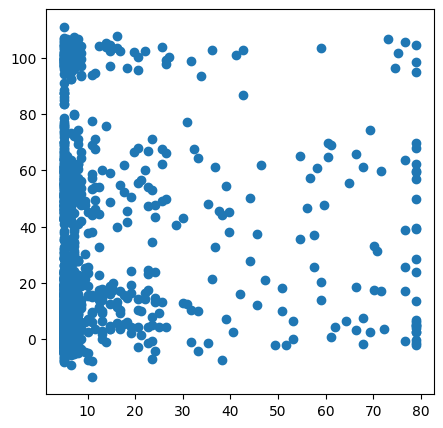

-4.718373391668246

In [27]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, random_state = 42, shuffle = True)
import lightgbm as lgb
verification = pd.DataFrame()
verification['y_test'] = df['current_crawds']

for train_idx, test_idx in kf.split(df):
    X_train = df.iloc[train_idx, :-1]
    y_train = df.iloc[train_idx, -1]
    X_test = df.iloc[test_idx, :-1]
    y_test = df.iloc[test_idx, -1]
    
    model = lgb.LGBMRegressor()
    model.fit(X_train, y_train)
    verification.loc[test_idx, 'y_pred'] = model.predict(X_test)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(verification['y_test'], verification['y_pred']) # 散布図を描画
plt.show()
from sklearn.metrics import r2_score
r2_score(verification['y_test'], verification['y_pred'])

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# データの読み込み
df = pd.read_csv('output1.csv')

# データの前処理
df = df.dropna()
df = df.drop(columns=['name', 'date'])

# hourカラムの前ゼロをつける処理
df['hour'] = df['hour'].apply(lambda x: x.zfill(5) if len(x) < 5 else x)
# hourカラムをint型に変換
df['hour'] = df['hour'].apply(lambda x: int(x.split(':')[0]))

# カテゴリカルデータのエンコーディング
categorical_features = ['hour', 'is_weekend_or_holiday', 'event_flag', 'weather_code', 'humidity', 'cloud', 'chance_of_rain']
df[categorical_features] = df[categorical_features].astype('category')

# 特徴量と目的変数の分割
X = df.drop('current_crawds', axis=1)
y = df['current_crawds']

# トレーニングデータとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMモデルの作成とトレーニング
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# テストデータを使って予測
y_pred = model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 特徴量の重要度を可視化
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 6
[LightGBM] [Info] Start training from score 40.496875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there

ValueError: not enough values to unpack (expected 2, got 0)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# データの読み込み
df = pd.read_csv('output1.csv')

# データの前処理
df = df.dropna()
df = df.drop(columns=['name', 'date'])

# hourカラムの前ゼロをつける処理
df['hour'] = df['hour'].apply(lambda x: x.zfill(5) if len(x) < 5 else x)
# hourカラムをint型に変換
df['hour'] = df['hour'].apply(lambda x: int(x.split(':')[0]))
df

,hour,is_weekend_or_holiday,event_flag,current_crawds,weather_code,temperature,humidity,cloud,chance_of_rain
10,17,1,1,79.00,1063,24.2,57,83,45
59,13,0,1,66.42,1000,25.4,55,4,0
64,18,0,1,79.00,1000,25.7,56,8,0
72,13,0,1,79.00,1000,28.5,50,8,0
89,17,1,1,76.78,1063,27.1,47,75,45
98,13,1,1,79.00,1000,27.7,53,3,0
102,17,1,1,61.24,1000,26.5,69,4,0
124,13,0,1,73.08,1189,18.7,93,100,100
129,18,0,1,60.50,1063,19.3,91,100,100
154,17,1,1,53.10,1000,24.5,73,6,0


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 7
[LightGBM] [Info] Start training from score 40.496875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

<Figure size 1000x600 with 0 Axes>

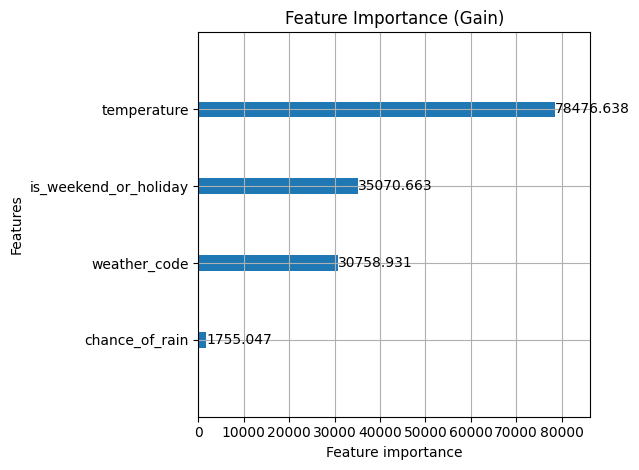

/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_82921/34058728.py:85: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_82921/34058728.py:85: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_82921/34058728.py:85: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_82921/34058728.py:85: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from current font.
  plt.tight_layout()
/Users/satoki252595/.pyenv/versions/3.11.7/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/satoki252595/.

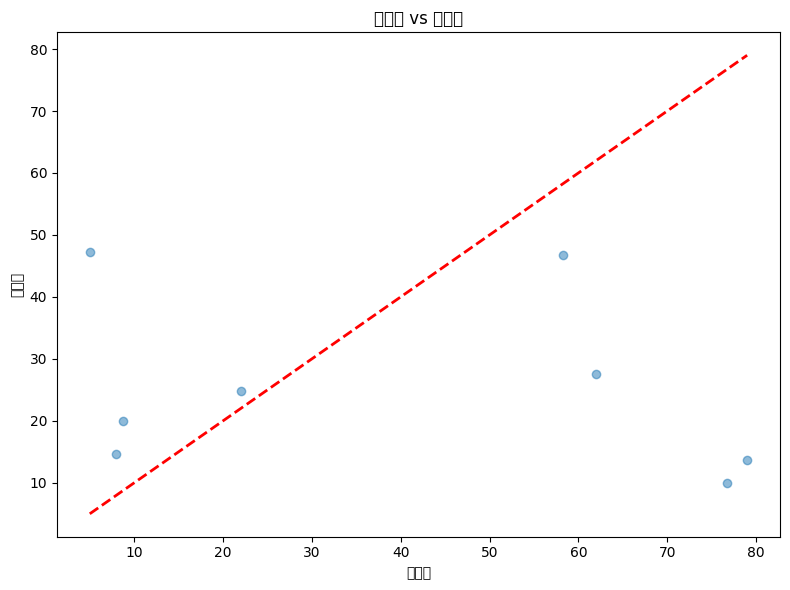

In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# データの読み込み
df = pd.read_csv('output1.csv')

# データの前処理
df = df.dropna()
df = df.drop(columns=['name', 'date'])

# hourカラムの前ゼロをつける処理
df['hour'] = df['hour'].apply(lambda x: x.zfill(5) if len(x) < 5 else x)

# hourカラムをint型に変換
df['hour'] = df['hour'].apply(lambda x: int(x.split(':')[0]))

# weather_codeカラムのエンコード
label_encoder = LabelEncoder()
df['weather_code'] = label_encoder.fit_transform(df['weather_code'])

# カテゴリカルデータのエンコーディング
categorical_features = ['hour', 'is_weekend_or_holiday', 'event_flag', 'weather_code', 'humidity', 'cloud', 'chance_of_rain']
df[categorical_features] = df[categorical_features].astype('category')

# 特徴量と目的変数の分割
X = df.drop('current_crawds', axis=1)
y = df['current_crawds']

# 数値型特徴量の正規化
numeric_features = ['temperature']
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのパラメータ設定
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5
}

# データセットの作成
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, reference=train_data)

# モデルの学習
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data])

# 予測と評価
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 評価指標の計算
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("モデル評価指標:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# 特徴量の重要度を可視化
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# 実測値と予測値の散布図
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('実測値')
plt.ylabel('予測値')
plt.title('実測値 vs 予測値')
plt.tight_layout()
plt.show()